# lstm으로 분류문제

문장이 주어졌을 때 스팸메일 분류하기

1. 데이터는 0, 1로 라벨링이 되어있다.

2. 언어 모델의 흐름
토큰화 > 정제 및 추출 > 인코딩 >
임베딩(w2v) > 

-> 서브클래싱에 적용
토큰화 > 정제 및 추출 > 인코딩 > keras.embedding

-> 서브 클래싱 코드 : init에 사용할 레이어 선언하고  forward에서 함수형 API 사용해서 레이어 연결한다. forward가 순전파라서 그냥 함수형 쓰듯이 하면된다.


3. 모델 선언

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable


class LSTM_net(nn.Module):
    def __init__(self, num_output, input_size, hidden_size, linear_size, num_layers, seq_length, device):
        super(LSTM_net, self).__init__()
        self.device = device
        self.num_output = num_output
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.num_layers = num_layers
        self.embed = nn.Embedding(size_vocab, dim_embed)

        '''
        1. bi를 지정 가능하다.
        '''
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers, dropout = 0.3, bidirectional = True) # lstm 레이어
        
        '''
        1. 분류 문제 마지막 단의 fcn1
        2. fcn의 입력으로 h * w인 y를 넣어도 되지만 그냥 h를 넣는 것과 다를 바가 없다. 그래서 hidden_size가 인풋
        > 그리고 거기서 나온 linear size가 다음 linear size로 가고 num_output에서 분류한다.
        '''
        self.fclayer = nn.Linear(hidden_size, linear_size) 
        self.outlayer = nn.Linear(linear_size, num_output) # fcn2

    


    # 순전파(역전파는 메인함수에서 돌릴 것이기 때문에 굳이 클래스에 쓸 필요는 없다. 없다면 메인에 있구나~라고 생각하라)

    def forward(self, x):
        scaler = 2 if self.lstm.bidirectional == True else 1 # bi면 2 아니면 1를 리턴

        # x는 정수 인코딩 결과이다.
        emb = self.embeded(x)

        # h, c state 초기화
        h_state = Variable(torch.zeros(self.num_layers*scaler, x.size(0),
                                       self.hidden_size, requires_grad = True)).to(self.device)


        c_state = Variable(torch.zeros(self.num_layers*scaler, x.size(0),
                                       self.hidden_size, requires_grad = True)).to(self.device)



        # transpose는 입력의 shape을 맞춰주기 위함 1, 2차원을 바꿔주는 것이다.
        lstm_out, (h, c) = self.lstm(emb).transpose(1,0), (h_state, c_state))
        
        h = h[-1] # h의 맨 마지막 인덱싱 (-1) : h이 배열에 저장되어있다.
        h = self.fclayer(h).relu() # 히든을 fcn에 넣어서 predict
        predict = self.outlayer(h)
        return predict

4.데이터 전처리

1) 0열이 text, 1열이 라벨 > iloc으로 0열 텍스트를 다 가져온다.

2) 바로 붙이진 말고 문장별로 토큰화하고 불용어 처리(정제 및 추출)하고 token text에 append한다.

-> 느낀게 있는데 원본 문장별로 학습을 시켜야 할까 아니면 토큰별로 다 쪼개서 append를 했는데 다 통으로 보는 걸까?

+알았다. 문장별로 본다. 원본 문장 하나를 불용어 처리하는 함수에 넣어서 제거하고 다시 1차 append로 붙이고 1차가 끝나면 token_text에 전부 붙인다.

[ ['i', 'am' ], ['he', 'is' ] ]이런 식이다.

3) 인코딩 : keras의 preprocessing의 texts to sequence에 넣으면 알아서 인코딩이 된다.  



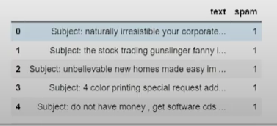

4) 라벨도 넘파이 행렬로 바꿔줘야한다. 위 작업을 거쳤으면 texts는 넘파이 행렬이다. 라벨도 넘파이로 만들어준다.(그러면 data api쓰기 좋다!!)

5) 패딩 : seq_len을 가급적 통일해주는 것이 좋다. 가장 긴 것을 기준으로 잡고 짧은 애들은 훈련을 할 때 "0이 나오기 전까지만 사용을 해라"라고 할 수 있다.

-> 근데 역시 자연어 처리는 개발자 직관이 성립한다고 했다. 지금 현재 최장 문장이 단어 수가 5500개이다. 일반적으로 스팸 메일은 앞에 두 문장만 봐도 알 수 있다.

그러니 개발자 직관대로 seq_len을 100으로 잡자(이럴 수 있다는 것이지 이러라는 건 아니다.)

5.데이터 셋 클래스 선언

데이터가 있으면 텐서로 바꿔야한다. return을 x, y 이런식으로 하면 데이터로더로 들어간다. (만들어 놓고 나중에 찾아 써라)

-> 데이터로더는 데이터셋을 배치 단위로 짜르는 애다. 셔플도 된다.

6.학습




# seq2seq를 이용한 NLP 번역

In [ ]:
class CNN_1D(nn.Module):
    def __init__(self, num_output, input_size, hidden_size, linear_size, kernel_size, seq_length, device):
        super(CNN_1D, self).__init__()
        self.device = device
        self.conv1 = nn.Conv1d(in_channels = input_size, out_channels = hidden_size, kernel_size = kernel_size)
        self.fclayer = nn.Linear(hidden_size * (seq_length - kernel_size + 1), linear_size)
        self.outlayer = nn.Linear(linear_size, num_output)

    def forward(self, x):
        x = self.conv1(x.transpose(1,2)).flatten(1)
        x = self.fclayer(x).relu()
        predict = self.outlayer(x)
        return predict

## seq2seq를 이용한 NLP 번역을 할 것이다

-> 데이터는 공개된 데이터이다. 독일어와 영어를 번역할 것이다.

```
↓ 아래 블럭에서 데이터를 불러 오면 토큰화 정제 및 추출, 인코딩, 까지 되어있다.

+ bos, eos까지 붙여준다.
```

In [ ]:
import nltk
import numpy as np
import re
import shutil
import tensorflow as tf
import os
import unicodedata

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def clean_up_logs(data_dir):
    checkpoint_dir = os.path.join(data_dir, "checkpoints")
    if os.path.exists(checkpoint_dir):
        shutil.rmtree(checkpoint_dir, ignore_errors=True)
        os.makedirs(checkpoint_dir)
    return checkpoint_dir


def preprocess_sentence(sent):
    sent = "".join([c for c in unicodedata.normalize("NFD", sent) 
        if unicodedata.category(c) != "Mn"])
    sent = re.sub(r"([!.?])", r" \1", sent)
    sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)
    sent = re.sub(r"\s+", " ", sent)
    sent = sent.lower()
    return sent


def download_and_read():
    en_sents, fr_sents_in, fr_sents_out = [], [], []
    local_file = os.path.join("datasets", "fra.txt")
    with open(local_file, "r") as fin:
        for i, line in enumerate(fin):
            en_sent, fr_sent = line.strip().split('\t')
            en_sent = [w for w in preprocess_sentence(en_sent).split()]
            fr_sent = preprocess_sentence(fr_sent)
            fr_sent_in = [w for w in ("BOS " + fr_sent).split()]
            fr_sent_out = [w for w in (fr_sent + " EOS").split()]
            en_sents.append(en_sent)
            fr_sents_in.append(fr_sent_in)
            fr_sents_out.append(fr_sent_out)
            if i >= num_sent_pairs - 1:
                break
    return en_sents, fr_sents_in, fr_sents_out

## 인, 디코더 선언

### 인코더 네트워크 구성 -> 두개로 구성된다.
1) 임베딩 : src문장을 임베딩을 통과시킨다.
-> 인자 : 1. vocabsize 행이 vocabsize인 lookup table을 만든다.

2.emb_dim : lookup table에서 열을 차지하는 임베딩 size


2) rnn : 임베딩 출력값을 GRU을 거친다.

-> 이후에 마지막의 hidden을 context vector로 사용한다.(return)

-> 인자 : 임베딩 size를 입력으로 받는다.

=> 결론 : 인코더는 이전에 스팸 메일 분류와 같은 모양이다. text를 인코딩하여 의미를 추출하는 것이 동일하기 때문이다.


In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, num_timesteps, 
            encoder_dim, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.encoder_dim = encoder_dim

        # 임베딩
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embedding_dim, input_length=num_timesteps)
        
        # rnn
        self.rnn = tf.keras.layers.GRU(
            # return_sequences=False: rnn 매 타임마다 출력하지 않고 마지막에만 출력을 한다.
            encoder_dim, return_sequences=False, return_state=True)

    # 객체 호출 메서드
    def call(self, x, state):
        x = self.embedding(x)
        x, state = self.rnn(x, initial_state=state)
        return x, state

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.encoder_dim))

## 디코더 네트워크 구성 

cv를 받아와서 lstm의 init hidden으로 사용하는 구조이다. -> 3가지이다.

1) 임베딩 : 입력이 들어오면 마찬가지로 임베딩 레이어를 거친다. 

2) rnn : 임베딩 레이어 결과가 rnn을 거친다.

3) fcn : 특이한게 fnc레이어가 하나 붙는다.

-> 왜 붙냐면 lstm의 출력은 번역 결과이다. 근데 그러기 위해서는 출력이 원핫된 결과여야한다. 그 원핫의 클래스 개수는 vocab_size와 똑같다. 그래야 rnn이 번역 결과로 어떤 단어를 선택할지 알 수 있을 것이니 말이다. 

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, num_timesteps,
            decoder_dim, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.decoder_dim = decoder_dim
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embedding_dim, input_length=num_timesteps)
        self.rnn = tf.keras.layers.GRU(
            decoder_dim, return_sequences=True, return_state=True)
        

        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, x, state):
        x = self.embedding(x)
        x, state = self.rnn(x, state)
        x = self.dense(x)
        return x, state

In [ ]:
def loss_fn(ytrue, ypred):
    scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    mask = tf.math.logical_not(tf.math.equal(ytrue, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    loss = scce(ytrue, ypred, sample_weight=mask)
    return loss


@tf.function
def train_step(encoder_in, decoder_in, decoder_out, encoder_state):
    with tf.GradientTape() as tape:
        encoder_out, encoder_state = encoder(encoder_in, encoder_state)
        decoder_state = encoder_state
        decoder_pred, decoder_state = decoder(decoder_in, decoder_state)
        loss = loss_fn(decoder_out, decoder_pred)
    
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss




def predict(encoder, decoder, batch_size, 
        sents_en, data_en, sents_fr_out, 
        word2idx_fr, idx2word_fr):
    random_id = np.random.choice(len(sents_en))
    print("input    : ",  " ".join(sents_en[random_id]))
    print("label    : ", " ".join(sents_fr_out[random_id]))

    # 인, 디코더 입력차원 배치 차원 생성
    encoder_in = tf.expand_dims(data_en[random_id], axis=0)
    decoder_out = tf.expand_dims(sents_fr_out[random_id], axis=0)

    # 인코더 초기 상태 0
    encoder_state = encoder.init_state(1)

    '''
    인코더의 출력에서 마지막 hidden state를 디코더의 초기 hidden으로 사용
    인코더에서 매 타임마다 출력을 하지 않게 해서 마지막 hidden을 뽑기 가능
    '''
    encoder_out, encoder_state = encoder(encoder_in, encoder_state)
    decoder_state = encoder_state

    decoder_in = tf.expand_dims(tf.constant([word2idx_fr["BOS"]]), axis=0)
    
    
    
    pred_sent_fr = []
    while True:
        decoder_pred, decoder_state = decoder(decoder_in, decoder_state)
        decoder_pred = tf.argmax(decoder_pred, axis=-1)
        pred_word = idx2word_fr[decoder_pred.numpy()[0][0]]
        pred_sent_fr.append(pred_word)

        # 디코더의 출력이 EOS면 break
        if pred_word == "EOS":
            break
        decoder_in = decoder_pred
    

    # 예측한 결과를 pred_에 append하고 join하여 최종 문장으로 만듬
    print("predicted: ", " ".join(pred_sent_fr))